<a href="https://colab.research.google.com/github/karinaleskiewicz06/Skin-Cancer-Classification-HAM10000/blob/main/skin_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: karinaleskiewicz
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000


100%|██████████| 5.20G/5.20G [01:11<00:00, 78.4MB/s]


In [3]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:

all_image_paths = {os.path.splitext(f)[0]: os.path.join(root, f)
                   for root, dirs, files in os.walk('/content/skin-cancer-mnist-ham10000')
                   for f in files if f.endswith('.jpg')}

data_df = pd.read_csv('/content/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

data_df['image_path'] = data_df['image_id'].map(all_image_paths)

data_df['labels'] = data_df['dx']

data_df = data_df.dropna(subset=['image_path'])

In [10]:
data_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,labels,label_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,bkl,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,bkl,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,bkl,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,bkl,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/skin-cancer-mnist-ham10000/HAM10000_i...,bkl,2


In [5]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    data_df,
    test_size=0.2,
    random_state=42,
    stratify=data_df['labels']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['labels']
)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 8012, Val size: 1001, Test size: 1002


In [7]:
label_encoder = LabelEncoder()
data_df["label_idx"] = label_encoder.fit_transform(data_df["labels"])
print(f"Class: {dict(enumerate(label_encoder.classes_))}")

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Opcjonalnie: standard dla ImageNet
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

Class: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}


In [11]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe['labels']))

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self,idx):
    img_path = self.dataframe.iloc[idx]['image_path']
    label = self.labels[idx]

    image = Image.open(img_path).convert('RGB')
    if self.transform:
        image = self.transform(image)

    return image, label

In [13]:
train_dataset = CustomImageDataset(dataframe = train_df, transform = train_transform)
val_dataset = CustomImageDataset(dataframe = val_df, transform = val_transform)
test_dataset = CustomImageDataset(dataframe = test_df, transform = val_transform)

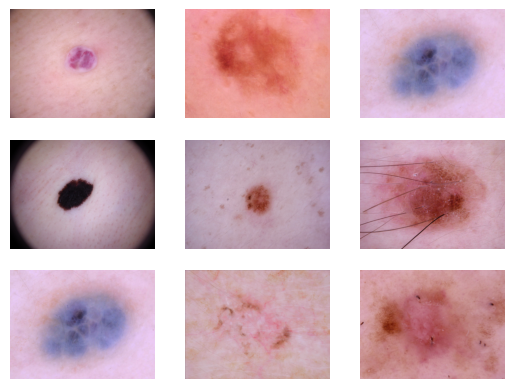

In [15]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range (n_rows):
  for col in range (n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')

plt.show()

In [24]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [17]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        self.flatten = nn.Flatten()


        self.linear = nn.Linear(128 * 16 * 16, 128)

        self.output = nn.Linear(128, len(data_df['labels'].unique()))

    def forward(self, x):
        x = self.relu(self.pooling(self.conv1(x)))
        x = self.relu(self.pooling(self.conv2(x)))
        x = self.relu(self.pooling(self.conv3(x)))

        x = self.flatten(x)

        x = self.dropout(x)

        x = self.relu(self.linear(x))
        x = self.output(x)
        return x

In [26]:
model = Net().to(device)

In [27]:
from torchsummary import summary
summary(model, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
          Dropout-11                [-1, 32768]               0
           Linear-12                  [-1, 128]       4,194,432
             ReLU-13                  [-1, 128]               0
           Linear-14                   

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [29]:
from prompt_toolkit import output
total_loss_train_plot = []
total_loss_validation_plot = []
total_loss_test_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  model.train()
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()

    total_acc_train += train_acc
    optimizer.step()

  model.eval()
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()

      total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train/len(train_loader),4))
    total_loss_validation_plot.append(round(total_loss_val/len(val_loader),4))

    total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__())*100,4))
    total_acc_validation_plot.append(round((total_acc_val/val_dataset.__len__())*100,4))

    print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/len(train_loader),4)}, Train Accuracy: {round((total_acc_train/train_dataset.__len__())*100,4)}
    Validation Loss: {round(total_loss_val/len(val_loader),4)}, Validation Accuracy: {round((total_acc_val/val_dataset.__len__())*100,4)}
          ''')



Epoch 1/25, Train Loss: 0.9854, Train Accuracy: 66.9621
    Validation Loss: 0.8985, Validation Accuracy: 68.8312
          
Epoch 2/25, Train Loss: 0.8755, Train Accuracy: 68.2227
    Validation Loss: 0.839, Validation Accuracy: 68.8312
          
Epoch 3/25, Train Loss: 0.8433, Train Accuracy: 68.8467
    Validation Loss: 0.8681, Validation Accuracy: 70.2298
          
Epoch 4/25, Train Loss: 0.8255, Train Accuracy: 69.7579
    Validation Loss: 0.8288, Validation Accuracy: 70.6294
          
Epoch 5/25, Train Loss: 0.795, Train Accuracy: 70.3694
    Validation Loss: 0.7707, Validation Accuracy: 71.9281
          
Epoch 6/25, Train Loss: 0.7652, Train Accuracy: 72.1043
    Validation Loss: 0.7567, Validation Accuracy: 72.8272
          
Epoch 7/25, Train Loss: 0.7373, Train Accuracy: 72.7659
    Validation Loss: 0.7453, Validation Accuracy: 73.6264
          
Epoch 8/25, Train Loss: 0.7287, Train Accuracy: 73.5647
    Validation Loss: 0.7434, Validation Accuracy: 72.4276
          
Ep

In [30]:
model.eval()
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    predictions = model(inputs)
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

    test_acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += test_acc

print(f"Accuracy Score is: {round(total_acc_test/test_dataset.__len__()*100,4)} and Loss is  {round(total_loss_test/len(test_loader),4)}")


Accuracy Score is: 74.3513 and Loss is  0.6796


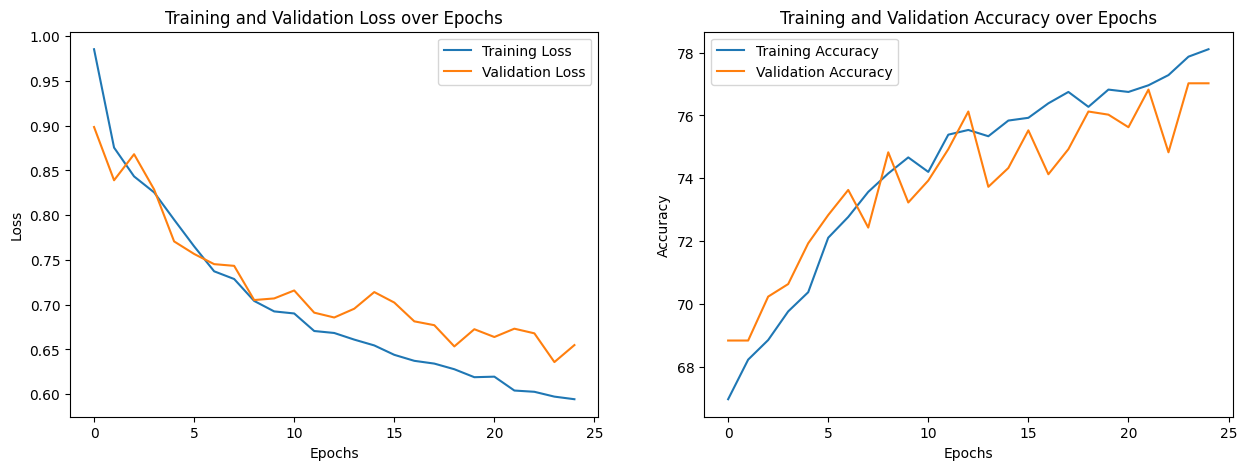

In [31]:
fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
axs[0].plot(total_loss_train_plot, label = 'Training Loss')
axs[0].plot(total_loss_validation_plot, label = 'Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'Training Accuracy')
axs[1].plot(total_acc_validation_plot, label = 'Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()